# Attention

In [ ]:
# 번역 데이터셋 다운로드
!echo "download machine translation dataset from http://www.manythings.org/anki/..."

!curl -o "fra-eng.zip" "http://www.manythings.org/anki/fra-eng.zip"

!unzip './fra-eng.zip'

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
flatten = lambda l: [item for sublist in l for item in sublist]

from torch.nn.utils.rnn import PackedSequence,pack_padded_sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
random.seed(7)
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# GPU 설정
USE_CUDA = torch.cuda.is_available() # 현재 환경에서 CUDA를 사용할 수 있는지 확인

# CUDA를 사용할 수 있으면 CUDA tensor를, 그렇지 않으면 CPU tensor를 사용
FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

## Seq2seq with Attention

### getBatch 함수 구현
`getBatch` 함수는 주어진 `train_data`에서 무작위로 선택된 배치를 생성하는 역할을 한다. 
- `train_data`를 무작위로 섞는다.
- `sindex`와 `eindex` 변수를 사용하여 `train_data`에서 배치를 추출한다.
- `eindex`를 `batch_size`만큼 증가시키고 `sindex`를 이전 `eindex` 값으로 업데이트한다.
- `eindex`가 `train_data`의 길이보다 작은 동안 위 과정을 반복하여 배치를 생성한다.
- `eindex`가 `train_data`의 길이보다 크거나 같아지면 남은 데이터를 마지막 배치로 생성한다.

In [5]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data) # 데이터를 무작위로 섞는다.
    sindex = 0 # 시작 인덱스
    eindex = batch_size # 종료 인덱스
    while eindex < len(train_data): 
        batch = train_data[sindex:eindex] # batch_size만큼 데이터를 불러온다.
        temp = eindex # 현재 인덱스를 저장
        eindex = eindex + batch_size # eindex를 배치 사이즈만큼 증가
        sindex = temp # sindex를 이전 eindex값으로 변경
        yield batch # batch를 반환

    if eindex >= len(train_data): 
        batch = train_data[sindex:] # 남은 데이터를 배치로 만든다.
        yield batch # batch를 반환

### pad_to_batch 함수 구현
`pad_to_batch` 함수는 주어진 배치에 패딩을 적용핳여 입력 시퀀스와 타겟 시퀀스를 동일한 길이로 만든다. 
- 배치를 길이에 따라 정렬
- 입력 시퀀스와 타겟 시퀀스의 길이를 계산
- 각 시퀀스에 패딩을 적용하여 동일한 길이로 변환
- 입력 변수와 타겟 변수를 생성하고 각 시퀀스의 실제 길이를 계산
- 입력 변수, 타겟 변수, 입력 길이, 타겟 길이를 반환


In [6]:
def pad_to_batch(batch, x_to_ix, y_to_ix):
    sorted_batch = sorted(batch, key=lambda b:b[0].size(1), reverse=True) # batch를 길이에 따라 내림차순으로 정렬
    x,y = list(zip(*sorted_batch)) # x와 y를 분리
    max_x = max([s.size(1) for s in x]) # 입력 데이터 최대 길이
    max_y = max([s.size(1) for s in y]) # 타겟 데이터 최대 길이
    x_p, y_p = [], [] # 패딩을 적용할 입력, 타겟 리스트

    for i in range(len(batch)):
        if x[i].size(1) < max_x: # 현재 데이터가 최대 길이보다 짧다면
            # 패딩을 적용하여 최대 길이로 만든다.
            x_p.append(torch.cat([x[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1))).view(1, -1))], 1))
        else:
            x_p.append(x[i]) # 그렇지 않으면 그대로 사용
        if y[i].size(1) < max_y: # 타겟 데이터가 최대 길이보다 짧다면
            # 패딩을 적용하여 최대 길이로 만든다.
            y_p.append(torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1))).view(1, -1))], 1))
        else:
            y_p.append(y[i]) # 그렇지 않으면 그대로 사용

    input_var = torch.cat(x_p) # 입력 데이터를 하나의 텐서로 만든다.
    target_var = torch.cat(y_p) # 타겟 데이터를 하나의 텐서로 만든다.
    input_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in input_var] # 입력 데이터의 각 문장의 실제 길이
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var] # 타겟 데이터의 각 문장의 실제 길이

    return input_var, target_var, input_len, target_len

### 데이터셋 load 및 preprocess 코드 구현
이 코드에서는 문자열을 처리하고 정규화 하는 두가지 함수를 구현한다.
- `unicode_to_ascii` 함수는 유니코드 문자열을 ASCII 문자열로 변환한다. 주어진 유니코드 문자열에서 각 문자를 순회하며 해당 문자가 비수치형인 경우에만 ASCII 문자열에 추가한다.

- `normalize_string` 함수는 문자열을 소문자로 변환하고 공백을 제거하며 영문자와 구두점 이외의 문자를 제거한다.

In [7]:
# 유니코드 문자열을 ASCII 문자열로 변환
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 문자열 정규화
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [8]:
corpus = open('../fra.txt', 'r', encoding='utf-8').readlines()

corpus = corpus[:30000]

len(corpus)

30000

### 데이터 전처리 및 필터링
기계 번역을 위한 데이터 전처리와 필터링을 수행한다.
최소 및 최대 길이를 설정하여 너무 짧거나 너무 긴 문장을 제외
- `MIN_LENGTH` : 문장의 최소 길이를 지정한다.
- `MAX_LENGTH` : 문장의 최대 길이를 지정한다.
빈 리스트 `X_r`, `y_r`을 생성한 뒤 각각 source와 target 문장을 저장

`corpus`의 각 문장에 대해 다음 작업을 수행
1. source와 target을 분리 (\t)으로 구분
2. source와 target이 비어있지 않은지 확인하고 비어있다면 해당 문장 건너 뜀
3. source와 target을 정규화 하고 공백을 분리한다.
4. source와 target의 길이가 최소 및 최대 길이 사이에 있는지 확인하고 `X_r`, `y_r`에 추가

In [9]:
MIN_LENTH = 3
MAX_LENGTH = 25

X_r, y_r = [], [] # row 데이터를 저장할 리스트

for parallel in corpus:
    so, ta, _ = parallel.split('\t') # 소스와 타겟을 분리
    if so.strip() == "" or ta.strip() == "": # 빈 문자열이라면 건너뛴다.
        continue
    
    normalized_so = normalize_string(so).split() # 소스 문장 정규화
    normalized_ta = normalize_string(ta).split() # 타겟 문장 정규화

    # 소스 문장과 타겟 문장의 길이가 최소 길이와 최대 길이 사이에 있으면 리스트에 추가
    if len(normalized_so) >= MIN_LENTH and len(normalized_so) <= MAX_LENGTH \
    and len(normalized_ta) >= MIN_LENTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)

print(len(X_r), len(y_r)) # 소스 문장과 타겟 문장의 개수 출력
print(X_r[0], y_r[0]) # 첫 번째 소스 문장과 타겟 문장 출력

29444 29444
['i', 'see', '.'] ['je', 'comprends', '.']


### 소스, 타겟 단어장 생성

소스와 타겟 데이터를 사용하여 각각의 단어 기반 단어장을 생성한다. 소스와 타겟 데이터를 flatten한 후 중복된 단어를 제거하기 위해 `set()`함수를 사용한다. 이렇게 생성된 단어장은 각각 `source_vocab`과 `targe_vocab`에 저장된다.

### 인덱스 매핑 생성
단어장을 기반으로 단어와 인덱스 사이의 매핑을 생성한다. `<PAD>`, `<UNK>`, `<s>`, `<\s>`와 같은 특수 토큰을 포함한 초기 매핑 딕셔너리를 생성한다.
`source2index`와 `target2index` 딕셔너리에 각각 소스와 타겟 단어장의 단어들을 추가한다. 인덱스와 단어 사이의 역매핑을 구성하여 추후 데이터 전처리 및 결과 해석에 사용된다.

In [10]:
# 소스와 타겟 단어장 생성
source_vocab = list(set(flatten(X_r))) # 소스 단어장
target_vocab = list(set(flatten(y_r))) # 타겟 단어장
print(len(source_vocab), len(target_vocab)) # 소스와 타겟 단어장의 크기 출력

source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3} # 소스 단어장을 인덱스로 변환하는 딕셔너리 초기화
for vo in source_vocab:
    if source2index.get(vo) is None: # 단어장에 없는 단어라면
        source2index[vo] = len(source2index) # 단어를 단어장에 추가
index2source = {v:k for k, v in source2index.items()} # 인덱스를 단어로 변환하는 딕셔너리

target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3} # 타겟 단어장을 인덱스로 변환하는 딕셔너리 초기화
for vo in target_vocab:
    if target2index.get(vo) is None: # 단어장에 없는 단어라면
        target2index[vo] = len(target2index) # 단어를 단어장에 추가
index2target = {v:k for k, v in target2index.items()} # 인덱스를 단어로 변환하는 딕셔너리

4268 7409


### prepare_sequence 함수와 데이터 전처리
- prepare_sequence 함수는 주어진 시퀀스를 인덱스로 변홚하는 함수로 seq와 to_index를 입력으로 받아 시퀀스의 각 단어를 인덱스로 변환하고 Variable로 변환하여 반환한다. 만약 단어가 to_index 딕셔너리에 없으면 unknown 토큰의 인덱스로 변환한다.

In [11]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index['<UNK>'], seq))
    return Variable(LongTensor(idxs)) # 변환된 인덱스를 텐서로 벼노한

X_p, y_p = [], [] # 인덱스로 변환된 소스와 타겟 데이터를 저장할 리스트

for so, ta in zip(X_r, y_r):
    X_p.append(prepare_sequence(so + ['</s>'], source2index).view(1, -1)) # 소스 데이터를 인덱스로 변환하여 리스트에 추가
    y_p.append(prepare_sequence(ta + ['</s>'], target2index).view(1, -1)) # 타겟 데이터를 인덱스로 변환하여 리스트에 추가

train_data = list(zip(X_p, y_p)) # 소스와 타겟 데이터를 묶어 리스트로 만든다.

train_data[:5] # 변환된 소스와 타겟 데이터 출력

[(tensor([[3844, 2176, 3081,    3]], device='cuda:0'),
  tensor([[5610, 4640, 3169,    3]], device='cuda:0')),
 (tensor([[3844, 3007, 3081,    3]], device='cuda:0'),
  tensor([[1744, 2019, 3169,    3]], device='cuda:0')),
 (tensor([[3844,  801, 1936,    3]], device='cuda:0'),
  tensor([[1744, 7071, 1081, 4546,    3]], device='cuda:0')),
 (tensor([[3844,  801, 1936,    3]], device='cuda:0'),
  tensor([[5610, 4268, 7071,  114, 4546,    3]], device='cuda:0')),
 (tensor([[3844,  801, 3081,    3]], device='cuda:0'),
  tensor([[1744, 7071, 1081, 3169,    3]], device='cuda:0'))]

### Encoder 구현

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, bidirec=False):
        super(Encoder, self).__init__()

        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # 임베딩 레이어 정의
        self.embedding = nn.Embedding(input_size, embedding_size)

        # 양방향 GRU를 사용할 것인지 여부에 따라 n_direction 설정 (양방향일 경우 2, 단방향일 경우 1)
        if bidirec:
            self.n_direction = 2
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)

    # hidden state 초기화
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers * self.n_direction, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    # 임베딩 레이어와 GRU 레이어의 가중치를 xavier_uniform 방식으로 초기화
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)

    # 순전파 정의
    def forward(self, inputs, input_lengths):
        hidden = self.init_hidden(inputs)

        embedded = self.embedding(inputs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        # 레이어 수가 1보다 크면, 마지막 두 레이어의 은닉 상태를 사용하고, 그렇지 않으면 마지막 레이어의 은닉 상태를 사용
        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]

        return outputs, torch.cat([h for h in hidden], 1).unsqueeze(1)

### Encoder 사용

In [14]:
BATCH_SIZE = 64
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512

encoder = Encoder(
    input_size=len(source2index),
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    n_layers=3,
    bidirec=True
).cuda()

encoder.init_weight() # 가중치 초기화

ex = next(iter(getBatch(BATCH_SIZE, train_data))) # 미니배치 데이터를 가져온다.
inputs, targets, input_lengths, target_lengths = pad_to_batch(ex, source2index, target2index)

output, hidden_c = encoder(
    inputs=inputs,
    input_lengths=input_lengths
)

print(output.size())

torch.Size([64, 7, 1024])


### Decoder 구현

In [15]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, input_size)
        self.attn = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)

    def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        # hidden 차원 변경
        hidden = hidden[0].unsqueeze(2) # (1,B,D) -> (B,D,1)

        # encoder_output의 크기 가져옴
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        # attention 에너지 계산
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) # B,T,D -> B*T,D -> B*T,1 
        energies = energies.view(batch_size, max_len, -1) # B,T,D
        attn_energies = energies.bmm(hidden).squeeze(2) # B,T,D * B,D,1 -> B,T

        # 소프트맥스를 통해 attention distribution 계산
        alpha = F.softmax(attn_energies, 1) # B,T
        alpha = alpha.unsqueeze(1) # B,1,T
        # context vector 계산
        context = alpha.bmm(encoder_outputs) # B,1,T * B,T,D -> B,1,D

        return context, alpha
    
    def forward(self, inputs, context, max_length, encoder_outputs, encoder_maskings=None, is_training=False):
        """
        inputs : B,1 (전 단계 출력)
        context : B,1,D (encoder 출력값)
        max_length : int decoding 최대 길이
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        is_training : bool, 드롭아웃을 training 때만 적용
        """
        # 입력 단어의 임베딩 계산
        embedded = self.embedding(inputs)
        # hidden state 초기화
        hidden = self.init_hidden(inputs)
        # training 때만 드롭아웃 적용
        if is_training:
            embedded = self.dropout(embedded)

        decode = []
        # GRU 적용
        for i in range(max_length):
            # GRU의 입력으로 embedded와 context를 연결하여 사용
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1}, y_{t-1}, c)
            # hidden과 context를 연겨하여 concated를 생성
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # y_t = g(h_t,y_{t-1},c)
            # 선형 레이어를 통해 score를 계산
            score = self.linear(concated.squeeze(0))
            # score에 softmax를 적용하여 확률값 계산
            softmaxed = F.log_softmax(score)
            # softmax 결과를 decode에 추가
            decode.append(softmaxed)
            # softmaxed 최대값 인덱스를 decode에 저장
            decoded = softmaxed.max(1)[1]
            # decoded를 임베딩ㅎ하여 embedded를 업데이트
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            # 훈련 단계에서만 드롭아웃 적용
            if is_training:
                embedded = self.dropout(embedded)
            
            # attention을 사용하여 다음 context 벡터 계산
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_maskings)

        # decode의 결과를 하나의 텐서로 만들어 반환
        scores = torch.cat(decode, 1)
        # scores 크기 변경
        return scores.view(inputs.size(0) * max_length, -1)
    
    # 디코딩 함수
    def decode(self, context, encoder_outputs):
        # 디코딩을 시작하는 심볼을 start_decode에 저장
        start_decode = Variable(LongTensor([[target2index['<s>']] * 1])).transpose(0, 1)
        # start_decode를 임베딩
        embedded = self.embedding(start_decode)
        # hidden state 초기화
        hidden = self.init_hidden(start_decode)

        decodes = []
        attentions = []
        decoded = embedded
        # decoded가 종료 심볼이 될 때까지 반복
        while decoded.data.tolist()[0] != target2index['</s>']: # </s>가 나올 때까지
            # GRU의 입력으로 embedded와 context를 연결하여 사용
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)
            # hidden과 context를 연결하여 concated를 생성
            concated = torch.cat((hidden, context.transpose(0, 1)), 2)
            # 선형 레이어를 통해 score를 계산
            score = self.linear(concated.squeeze(0))
            # score에 softmax를 적용하여 확률값 계산
            softmaxed = F.log_softmax(score)
            # softmaxed 최대값 인덱스를 decode에 저장
            decoded = softmaxed.max(1)[1]
            # decoded를 임베딩하여 embedded를 업데이트
            embedded = self.embedding(decoded).unsqueeze(1)
            # attention을 사용하여 다음 context 벡터 계산
            context, alpha = self.Attention(hidden, encoder_outputs, None)
            # decoded 결과를 decodes에 추가
            decodes.append(decoded)
            # attention 결과를 attentions에 추가
            attentions.append(alpha)

        # decodes와 attentions를 하나의 텐서로 만들어 반환
        return torch.cat(decodes).squeeze(), torch.cat(attentions)

### Seq2seq 번역 학습

In [17]:
EPOCH = 5
BATCH_SIZE =256
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
LR = 0.001
DECODER_LEARNING_RATIO = 5.0
RESCHEDULED = False

encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True)
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)

encoder.init_weight()
decoder.init_weight()

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=0)

enc_optim = optim.Adam(encoder.parameters(), lr=LR)
dec_optim = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)

for epoch in range(EPOCH):
    losses=[] # 손실을 저장할 리스트
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)): # 배치 사이즈만큼 데이터를 가져옴
        inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source2index, target2index) # 배치 데이터를 패딩

        # 입력 데이터에 대한 마스크 생성
        input_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in inputs]).view(inputs.size(0), -1)
        start_decode = Variable(LongTensor([[target2index['<s>']] * targets.size(0)])).transpose(0, 1) # 디코딩 시작 토큰 설정
        encoder.zero_grad() # 인코더의 그래디언트 초기화
        decoder.zero_grad() # 디코더의 그래디언트 초기화
        output, hidden_c = encoder(inputs, input_lengths) # 인코더를 통해 출력과 히든 상태 얻음

        # 디코더를 통해 예측값 생성
        preds = decoder(start_decode, hidden_c, targets.size(1), output, input_masks, True)

        loss = loss_function(preds, targets.view(-1)) # 손실 계산
        losses.append(loss.data.tolist() ) # 손실 저장
        loss.backward() # 역전파 수행
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 50.0) # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 50.0) # 그래디언트 클리핑
        enc_optim.step() # 인코더 파라미터 업데이트
        dec_optim.step() # 디코더 파라미터 업데이트

        # 일정 간격으로 손실 출력
        if i % 50 == 0 or i % len(train_data) == 0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" %(epoch, EPOCH, i, len(train_data)//BATCH_SIZE, np.mean(losses)))
            losses=[]

    # 학습 중간에 학습률 재조정
    if RESCHEDULED == False and epoch  == EPOCH//2:
        LR *= 0.01
        enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)
        RESCHEDULED = True

[00/5] [000/115] mean_loss : 8.91
[00/5] [050/115] mean_loss : 5.00
[00/5] [100/115] mean_loss : 3.93
[01/5] [000/115] mean_loss : 3.68
[01/5] [050/115] mean_loss : 3.29
[01/5] [100/115] mean_loss : 2.99
[02/5] [000/115] mean_loss : 2.60
[02/5] [050/115] mean_loss : 2.54
[02/5] [100/115] mean_loss : 2.38
[03/5] [000/115] mean_loss : 2.22
[03/5] [050/115] mean_loss : 2.06
[03/5] [100/115] mean_loss : 1.97
[04/5] [000/115] mean_loss : 1.83
[04/5] [050/115] mean_loss : 1.68
[04/5] [100/115] mean_loss : 1.67


### 어텐션 시각화 함수 및 결과 확인

Source :  no one knew that .
Truth :  personne ne savait ca .
Prediction :  personne ne le cela .


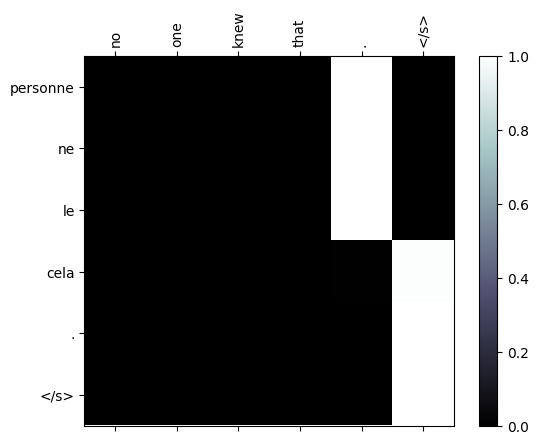

In [19]:
def show_attention(input_words, output_words, attentions):
    attentions = attentions.squeeze(1)
    # 색상 바를 가진 plot 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone') # attention을 나타내는 행렬을 plot으로 표현
    fig.colorbar(cax) # 색상 바 추가

    # 축 설정
    ax.set_xticklabels([''] + input_words, rotation=90) # x축에 입력 단어 설정
    ax.set_yticklabels([''] + output_words) # y축에 출력 단어 설정

    # 모든 눈금에 레이블 표시
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show() # plot 표시
    plt.close()


test = random.choice(train_data) # 학습 데이터에서 무작위로 하나 선택
input_ = test[0] # 입력 데이터
truth = test[1] # 실제 값

output, hidden = encoder(input_, [input_.size(1)]) # 인코더를 통해 출력과 히든 상태 얻음
pred, attn = decoder.decode(hidden, output) # 디코더를 통해 예측값과 attention 얻음

input_ = [index2source[i] for i in input_.data.tolist()[0]] # 입력 데이터를 단어로 변환
pred = [index2target[i] for i in pred.data.tolist()] # 예측값을 단어로 변환

# 결과 출력
print('Source : ',' '.join([i for i in input_ if i not in ['</s>']])) # 입력 문장 출력
print('Truth : ',' '.join([index2target[i] for i in truth.data.tolist()[0] if i not in [2, 3]])) # 실제 문장 출력
print('Prediction : ',' '.join([i for i in pred if i not in ['</s>']])) # 예측 문장 출력

if USE_CUDA:
    attn = attn.cpu() # CUDA를 사용하는 경우, attention을 CPU로 이동

show_attention(input_, pred, attn.data) # attention을 plotting